<h1>Evaluation of Taxonomic Diversity of the Hadza<br/> between Dry and Wet Seasons</h1>

Here, we list out the steps taken for the evaluation of taxonomic diversity as a function of seasonality in the Hadza microbiome. Our analyses involved casting a wide net for sequencing data and limiting these data to those that are reliably biological given current reference databases. These methods are optimized for maximizing sequencing data resolving power for an accurate picture of taxonomic diversity. We further examine effects of normality and rarefaction.

<h2>Style</h2>  
This notebook contains a mixture of command-line functions and python (in-line) functions. The command-line functions are performed within a terminal client, and the style for relevant commands are listed as such:

```
echo "This line is to be run within a terminal client"
```

<h2>Raw Sequence processing steps</h2>
<h3>Demultiplexing and OTU Picking</h3>
1. <b>Demultiplexing</b> was performed using QIIME v1.9.1. Demultiplexing involves splitting the sequencing data within runs according to samples that are labeled by unique barcodes (provided in a mapping file). Here, our sequencing was performed using three sequencing runs, labeled R1, R2, R3:
```
split_libraries_fasta.py -i SS-R1_lane1.gz,SS-R2_lane1.gz,SS-R3_lane1.gz -b SS-R1_barcodes.gz,SS-R2_barcodes.gz,SS-R3_barcodes.gz -m mapping/R1-mapping_all.txt,mapping/R2-mapping_all.txt,mapping/R3-mapping_all.txt -o split_libraries -q 10 --rev_comp_mapping_barcodes
```
Parameters: <br/>
 <i>-i</i>: input sequences; here we have three sequencing runs <br/>
 <i>-b</i>: barcode sequences; here we reference the barcodes relating to the three runs <br/>
 <i>-m</i>: mapping files; here we reference three mapping files that include the barcodes for demultiplexing <br/>
 <i>-o</i>: output directory; here we indicate the name of the output directory to save demultiplexed sequences<br/>
 <i>-q</i>: phred cutoff; here we use a phred cutoff score of at least 10, optimizing resolution<br/>
 <i>--rev_comp_mapping_barcodes</i>: here we ask reverse complements of barcodes to be evaluated, ensuring we're not missing reads<br/><br/>
2. <b>OTU Picking</b> was performed using QIIME v1.9.1. QIIME performs OTU picking (with `pick_open_reference_otus.py`) by first clustering sequences to a reference sequence database (Greengenes) using an identity threshold. OTUs that do not successfully cluster (novel sequences not captured in reference databases) are then clustered <i>de novo</i>. These subsequent steps are sensitive to number of representative sequences "seeded" for clustering, and are opportunities for rarer sequences to not be enumerated (Bokulich <i>et al.</i>); an important caveat when considering taxonomic diversity evaluation.
```
pick_open_reference_otus.py -i split_libraries/seqs.fna -o pick_open --min_otu_size 2 -aO 3
```
Parameters: <br/>
 <i>-i</i>: input sequences; here we reference the split libraries sequence file <br/>
 <i>-o</i>: output directory; here we indicate a directory to output the OTU tables <br/>
 <i>--min_otu_size</i>: minimum number of OTUs required to retain a cluster; here we set at least 2 OTUs<br/>
 <i>-aO</i>: parallel processing; here we indicate that this should be performed across 3 job threads<br/>
 

<h2>Identifying thresholds for stringency</h2>

Libraries and statistical packages used in our analyses are imported:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial import ConvexHull
from scipy.stats import ranksums
from sklearn.decomposition import PCA

%load_ext rpy2.ipython

<h3>Total unique OTUs after filtering for minimum OTU counts</h3>

Here we evaluate the effect on the number of unique OTUs as a function of filtering by a minimum count 
of an OTU present in the OTU table.

First, we filter the OTUs by those that are present in samples that have at least 13k OTUs assigned:

```
mkdir otu_tables
filter_samples_from_otu_table.py -i otu_table_mc2_w_tax_no_pynast_failures.biom -o otu_tables/otu_table.biom --sample_id_fp mapping/sample_ids.txt
single_rarefaction.py -i otu_tables/otu_table.biom -o otu_tables/otu_table_d13k.biom -d 13000
biom convert -i otu_tables/otu_table_d13k.biom -o otu_tables/otu_table_d13k.biom.tsv --header-key taxonomy --to-tsv
```

Then, we create otu tables that filter from 1 to 130 minimum OTU counts:

```
for n in $(seq 1 13); do
  echo "Processing n=${n}"
  filter_otus_from_otu_table.py -i otu_tables/otu_table_d13k.biom -o otu_tables/otu_table_d13k_n${n}.biom -n ${n}
  biom summarize-table -i otu_tables/otu_table_d13k_n${n}.biom -o otu_tables/otu_table_d13k_n${n}.biom.txt
done;

for n in $(seq 20 10 130); do
  echo "Processing n=${n}"
  filter_otus_from_otu_table.py -i otu_tables/otu_table_d13k.biom -o otu_tables/otu_table_d13k_n${n}.biom -n ${n}
  biom summarize-table -i otu_tables/otu_table_d13k_n${n}.biom -o otu_tables/otu_table_d13k_n${n}.biom.txt
done;
```

Now, we read the summarized tables to obtain unique OTU counts per threshold:

In [5]:
# Retrieves the number of unique OTU observations within a BIOM table 
# using the output of `biom summarize-table`
def getNumberOfObservedOTUs(file_ref):
    with open(file_ref, 'r') as file_ref_read:
        for line in file_ref_read:
            if line.startswith("Num observations:"):
                return int(line.split(":")[1].strip())

# Create Matrix
numberObservationsByMinOTUs = []
for n in range(1, 14):
    numberObservationsByMinOTUs.append([n, getNumberOfObservedOTUs('./otu_tables/otu_table_d13k_n' + str(n) + '.biom.txt')])
for n in range(20, 140, 10):
    numberObservationsByMinOTUs.append([n, getNumberOfObservedOTUs('./otu_tables/otu_table_d13k_n' + str(n) + '.biom.txt')])
    
# Create Dataframe
numberObservationsByMinOTUsDF = pd.DataFrame(numberObservationsByMinOTUs)
numberObservationsByMinOTUsDF.columns=["n", "OTUs"]

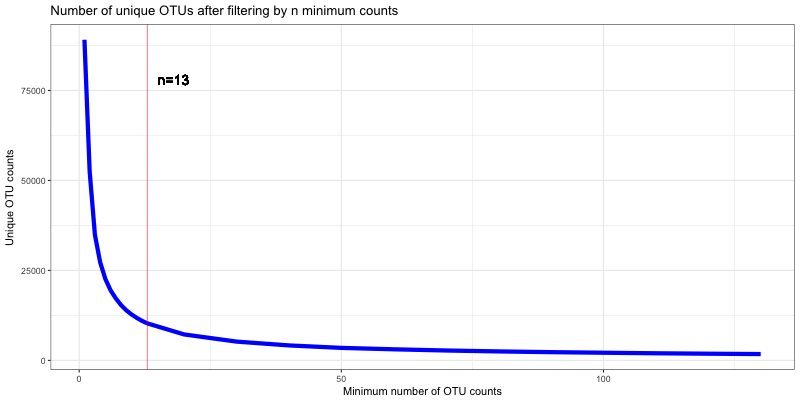

In [6]:
%%R -w 800 -h 400 -i numberObservationsByMinOTUsDF
library(ggplot2)

p <- ggplot(numberObservationsByMinOTUsDF, aes(x=n, y=OTUs)) + 
    geom_line(color="blue", size=2) +
    geom_vline(xintercept=13, color="red", alpha=0.5) +
    geom_text(aes(label = "n=13", y=78000, x=18), size=5, fontface=1)+
    ggtitle('Number of unique OTUs after filtering by n minimum counts') +
    xlab('Minimum number of OTU counts') + ylab('Unique OTU counts') +
    theme_bw() + theme(legend.position="none")
print(p)

<h2>Taxonomic Diversity</h2>

<h3>Simple/Default taxonomy plots</h3>

Having established a stringent cutoff, we first begin with simple diversity statistics produced by QIIME by default:
```
mkdir adiv_otu_tables
alpha_diversity.py -i otu_tables/otu_table_d13k_n13_d11k.biom -o adiv_otu_tables/adiv_d13k_n13_d11k.txt -t rep_set.tre
```

In [7]:
# Load mapping file
mapping = pd.read_csv('./mapping/mapping_all.txt', sep="\t")

# Load `alpha_diversity.py` output
alpha_div = pd.read_csv('./adiv_otu_tables/adiv_d13k_n13_d11k.txt', sep="\t")
alpha_div.columns = ['#SampleID'] + alpha_div.columns.tolist()[1:] # Label first column for merging with mapping

# Label and melt
alpha_div = mapping.merge(alpha_div)[alpha_div.columns.tolist() + ['SEASON']]
alpha_div_melt = pd.melt(alpha_div, id_vars=['#SampleID', 'SEASON'])

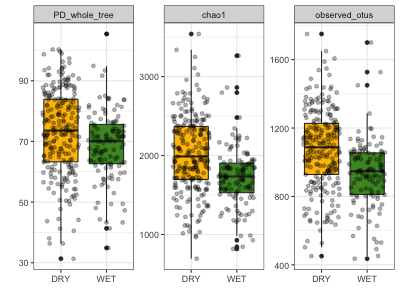

In [8]:
%%R -w 400 -h 300 -i alpha_div_melt
library(ggplot2)
seasonal_colors = c('#FFBF00', '#4A942C', '#FFBF00')

alpha_div_melt$variable_f = factor(alpha_div_melt$variable, levels=c('PD_whole_tree', 'chao1', 'observed_otus'))

p <- ggplot(alpha_div_melt, aes(x=SEASON, y=value, fill=SEASON)) + 
    geom_boxplot() +
    geom_jitter(alpha=0.3) +
    xlab('') + ylab('') +
    facet_wrap(~variable_f, scale="free") +
    scale_fill_manual(values = seasonal_colors) +
    theme_bw() + guides(fill=FALSE)
print(p)

In [9]:
print "Wilcoxon Rank Sum Tests"
print "Observed OTUS: ", ranksums(alpha_div[alpha_div.SEASON == "DRY"].observed_otus, alpha_div[alpha_div.SEASON == "WET"].observed_otus)
print "Chao1: ", ranksums(alpha_div[alpha_div.SEASON == "DRY"].chao1, alpha_div[alpha_div.SEASON == "WET"].chao1)
print "PD_Whole_Tree: ", ranksums(alpha_div[alpha_div.SEASON == "DRY"].PD_whole_tree, alpha_div[alpha_div.SEASON == "WET"].PD_whole_tree)

Wilcoxon Rank Sum Tests
Observed OTUS:  RanksumsResult(statistic=5.885929181635432, pvalue=3.9582378885693619e-09)
Chao1:  RanksumsResult(statistic=5.8375150907966038, pvalue=5.2985096966479441e-09)
PD_Whole_Tree:  RanksumsResult(statistic=3.2676728897195098, pvalue=0.0010843561400389293)


<h3>Taxonomic Diversity Distributions</h3>

While our statistical approach is robust to non-equivalent distributions, we evaluate the normality of the diversity distributions and apply transformations to rectify non-normal features. T-tests are then applied.<br/>

In [10]:
# Import additional libraries required for these analyses
from scipy.stats.mstats import normaltest
import skbio.diversity.alpha as alpha

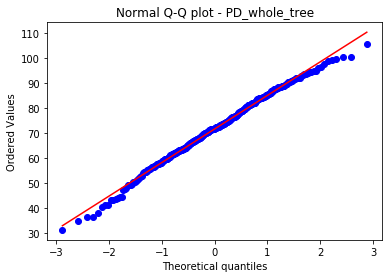

NormaltestResult(statistic=3.428423531957018, pvalue=0.1801056301619926)


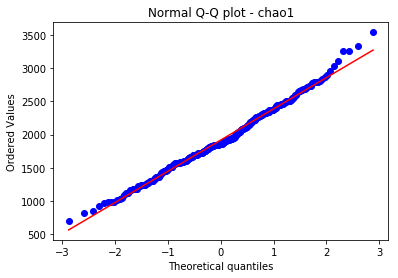

NormaltestResult(statistic=6.5102554611526635, pvalue=0.038575893027626922)


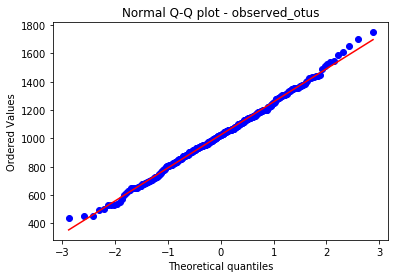

NormaltestResult(statistic=0.84642472914057199, pvalue=0.65493953238993718)


In [11]:
# Evaluate normality
# Visualize Q-Q plot and p-values for testing null hypotheses that these are normal distributions
# e.g. a p-value > 0.05 does NOT reject the hypotheses that these are normal distributions
alphaMetrics = ['PD_whole_tree', 'chao1', 'observed_otus']
for alphaMetric in alphaMetrics:
    stats.probplot(alpha_div[alphaMetric], dist="norm", plot=plt)
    plt.title("Normal Q-Q plot - " + alphaMetric)
    plt.show()
    print normaltest(alpha_div[alphaMetric])

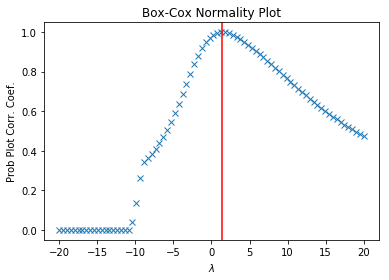

1.40128409179


In [12]:
# Visualize Box-Cox for PD-whole-tree
x = alpha_div['PD_whole_tree']

fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(x, -20, 20, plot=ax)
_, maxlog = stats.boxcox(x)
ax.axvline(maxlog, color='r')
plt.show()
print maxlog

In [13]:
# Normalize distributions using Box-Cox
alpha_div_transformed = alpha_div[['#SampleID', 'SEASON']].copy()
xt, x = stats.boxcox(alpha_div['PD_whole_tree'])
alpha_div_transformed['PD_whole_tree_transformed'] = (alpha_div['PD_whole_tree']**x - 1)/x

xt, x = stats.boxcox(alpha_div['chao1'])
alpha_div_transformed['chao1_transformed'] = (alpha_div['chao1']**x - 1)/x

xt, x = stats.boxcox(alpha_div['observed_otus'])
alpha_div_transformed['observed_otus_transformed'] = (alpha_div['observed_otus']**x - 1)/x

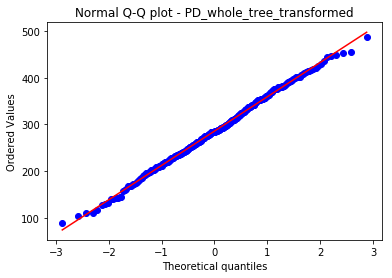

NormaltestResult(statistic=0.8626164248187087, pvalue=0.64965864705758603)


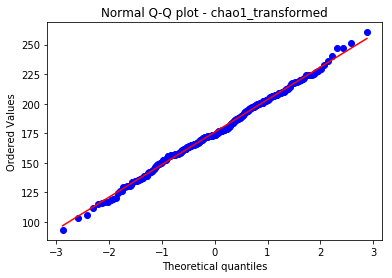

NormaltestResult(statistic=0.51310608736052554, pvalue=0.77371395283545086)


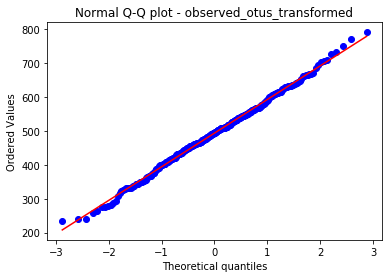

NormaltestResult(statistic=0.27859624244194692, pvalue=0.86996863368334698)


In [14]:
# Visualize Q-Q plot and p-values for testing null hypotheses that these are normal distributions
# e.g. a p-value > 0.05 does NOT reject the hypotheses that these are normal distributions
alphaMetrics = ['PD_whole_tree_transformed', 'chao1_transformed', 'observed_otus_transformed']
for alphaMetric in alphaMetrics:
    stats.probplot(alpha_div_transformed[alphaMetric], dist="norm", plot=plt)
    plt.title("Normal Q-Q plot - " + alphaMetric)
    plt.show()
    print normaltest(alpha_div_transformed[alphaMetric])
    
# Melt for R presentation
alpha_div_melt_transformed = pd.melt(alpha_div_transformed, id_vars=['#SampleID', 'SEASON'])

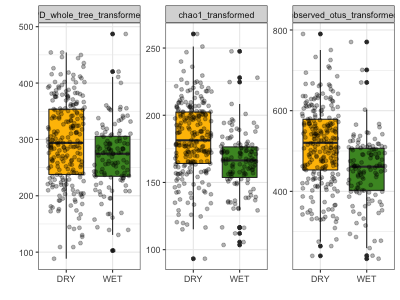

In [15]:
%%R -w 400 -h 300 -i alpha_div_melt_transformed
library(ggplot2)
seasonal_colors = c('#FFBF00', '#4A942C')

alpha_div_melt_transformed$variable_f = factor(alpha_div_melt_transformed$variable, levels=c('PD_whole_tree_transformed', 'chao1_transformed', 'observed_otus_transformed'))

p <- ggplot(alpha_div_melt_transformed, aes(x=SEASON, y=value, fill=SEASON)) + 
    geom_boxplot() +
    geom_jitter(alpha=0.3) +
    xlab('') + ylab('') +
    facet_wrap(~variable_f, scale="free") +
    scale_fill_manual(values = seasonal_colors) +
    theme_bw() + guides(fill=FALSE)
print(p)

In [16]:
# Now apply t-tests
print "Observed OTUS: ", stats.ttest_ind(alpha_div[alpha_div.SEASON == "DRY"].observed_otus, alpha_div[alpha_div.SEASON == "WET"].observed_otus)
print "Chao1: ", stats.ttest_ind(alpha_div[alpha_div.SEASON == "DRY"].chao1, alpha_div[alpha_div.SEASON == "WET"].chao1)
print "PD_Whole_Tree: ", stats.ttest_ind(alpha_div[alpha_div.SEASON == "DRY"].PD_whole_tree, alpha_div[alpha_div.SEASON == "WET"].PD_whole_tree)

Observed OTUS:  Ttest_indResult(statistic=5.6824908862002825, pvalue=2.8088942834764584e-08)
Chao1:  Ttest_indResult(statistic=5.7547554932407214, pvalue=1.9043831555339156e-08)
PD_Whole_Tree:  Ttest_indResult(statistic=2.9883228258524679, pvalue=0.0030044142265465432)


<h3>Comprehensive Diversity Measures</h3>

Here we go beyond the three default diversity metrics provided by QIIME's `alpha_diversity.py` script and
evaluate both the distributions and the metrics across seasons.

In [17]:
# Load BIOM
biom = pd.read_csv('./otu_tables/otu_table_d13k_n13_d11k.biom.tsv', sep="\t", skiprows=1)
biom_m = biom.iloc[:,1:]

# Enumerate types of alpha diversity metrics
alpha_diversity_metrics = {
    'PD_whole_tree' : 'PD_whole_tree',
    'observed_otus': alpha.observed_otus,
    'shannon': alpha.shannon,
    'simpson': alpha.simpson,
    'simpson_evenness': alpha.simpson_e,
    'gini_index': alpha.gini_index,
    'chao1': alpha.chao1
}

# Retrieve Sample IDs for samples in either wet/dry seasons to simplify selection below
season_ids = {
    "DRY": mapping[mapping.SEASON == "DRY"]['#SampleID'].tolist(),
    "WET": mapping[mapping.SEASON == "WET"]['#SampleID'].tolist()
}

# Build out a dataframe that is constructed with samples by rows, and
# the Alpha Diversity Metric Type (per sample), Season (`group`) and 
# the calculated Alpha Diversity Metric (`x`)
full_list_alpha = []
for season in season_ids:
    for sample_id in season_ids[season]:
        for alpha_diversity_metric in alpha_diversity_metrics:
            if alpha_diversity_metric == "PD_whole_tree":
                alpha_diversity = alpha_div.loc[alpha_div['#SampleID'] == sample_id, "PD_whole_tree"].tolist()[0]
            else:
                alpha_diversity = alpha_diversity_metrics[alpha_diversity_metric](biom_m[str(sample_id)].astype('int'))
            full_list_alpha.append([alpha_diversity_metric, season, alpha_diversity])
            
alphaMetrics = pd.DataFrame(full_list_alpha, columns=['Alpha_Metric', 'Group', 'x'])

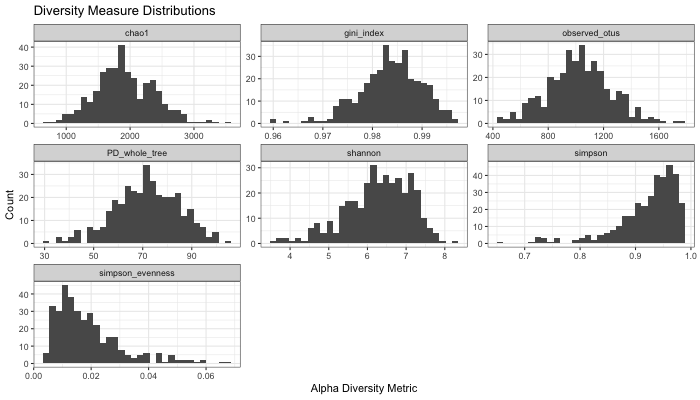

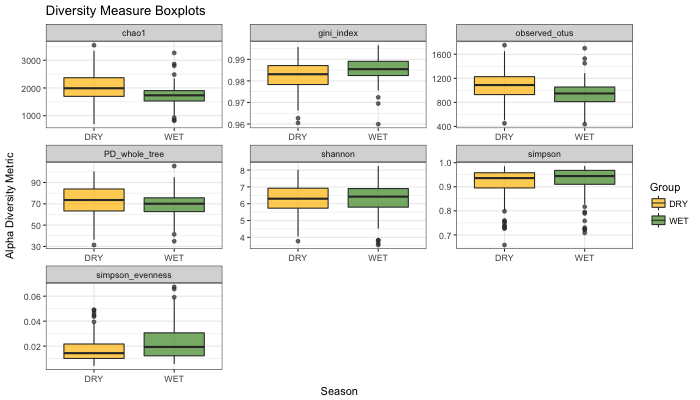

In [18]:
%%R -h 400 -w 700 -i alphaMetrics
library(ggplot2)
seasonal_colors = c('#FFBF00', '#4A942C')

alphaMetrics$x <- as.numeric(as.character(alphaMetrics$x))
alphaMetrics$Group <- factor(alphaMetrics$Group)
alphaMetrics$Alpha_Metric <- factor(alphaMetrics$Alpha_Metric)

p <- ggplot(alphaMetrics, aes(x=x)) +
    ggtitle('Diversity Measure Distributions') +
    geom_histogram() +
    facet_wrap( ~ Alpha_Metric, scales = "free") +
    xlab('Alpha Diversity Metric') +
    ylab('Count') +
    theme_bw()
print(p)

p <- ggplot(alphaMetrics, aes(x=Group, y=x, fill=Group)) +
    ggtitle('Diversity Measure Boxplots') +
    geom_boxplot(alpha=0.7) +
    facet_wrap( ~ Alpha_Metric, scales = "free") +
    ylab('Alpha Diversity Metric') +
    xlab('Season') +
    scale_fill_manual(values = seasonal_colors) +
    theme_bw()
print(p)

<h2>Rarefaction Analyses</h2>

Finally, we evaluate the effect of sampling at various depths and filtering parameters.

<h3>Effect of filtering minimum count OTUs on diversity metrics</h3>

Here we calculate diversity metrics across each assessed level of minimum count OTUs required. Increasing the minimum count OTU threshold decreases the number of OTUs that meet this threshold, effectively reducing the `observed otu` count. Therefore, here we perform rarefaction dynamically at the level of the sample with the fewest observed OTU counts (eg. a sample has 13000 OTUs, but using a min OTU threshold of n=100, only 10000 OTUs qualify, and the subsequent rarefaction step will then be no more than 10000). 



In [ ]:
# Retrieves the minimum number of OTU observations observed within a sample
# from the output of `biom summarize-table`
def getMinNumberOfObservedOTUs(file_ref):
    with open(file_ref, 'r') as file_ref_read:
        for line in file_ref_read:
            if line.startswith(" Min:"):
                return int(float(line.split(":")[1].strip()))

# NOTE: Running this cell will launch these series of operaions!
!mkdir adiv_min_otus
!alpha_diversity.py -i otu_tables/otu_table_d13k.biom -o adiv_min_otus/adiv_otu_table_d13k_n1_d13000.txt -t rep_set.tre
for n in range(2,14):
    d_count = getMinNumberOfObservedOTUs("./otu_tables/otu_table_d13k_n" + str(n) + ".biom.txt")
    !single_rarefaction.py -i otu_tables/otu_table_d13k_n{n}.biom -o otu_tables/otu_table_d13k_n{n}_d{d_count}.biom -d {d_count}
    !alpha_diversity.py -i otu_tables/otu_table_d13k_n{n}_d{d_count}.biom -o adiv_min_otus/adiv_otu_table_d13k_n{n}_d{d_count}.txt  -t rep_set.tre
    
for n in range(20,140,10):
    d_count = getMinNumberOfObservedOTUs("./otu_tables/otu_table_d13k_n" + str(n) + ".biom.txt")
    !single_rarefaction.py -i otu_tables/otu_table_d13k_n{n}.biom -o otu_tables/otu_table_d13k_n{n}_d{d_count}.biom -d {d_count}
    !alpha_diversity.py -i otu_tables/otu_table_d13k_n{n}_d{d_count}.biom -o adiv_min_otus/adiv_otu_table_d13k_n{n}_d{d_count}.txt  -t rep_set.tre   

In [20]:
# Retrieves diversity metric table outputted from QIIME script `alpha_diversity.py` and
# reformats it for inclusion in a concatenated dataframe
def getDiversityMetricsFromFile(file_ref, n):
    # Construct DataFrame for all raw values
    adivDF = pd.read_csv(file_ref, sep="\t")
    adivDF.columns = ['#SampleID'] + adivDF.columns.tolist()[1:] # Add label to column
    adivDF['n'] = str(n)
    return adivDF

# Here we build out a dataframe that concatenates all of the outputted alpha diversity metrics
# using QIIME. 
sort_n = [1] # Sorting for plot
adiv_min_otusDF = getDiversityMetricsFromFile("./adiv_min_otus/adiv_otu_table_d13k_n1_d13000.txt", 1)
for n in range(2,14):
    d_count = getMinNumberOfObservedOTUs("./otu_tables/otu_table_d13k_n" + str(n) + ".biom.txt")    
    adiv_min_otusDF = pd.concat([
        adiv_min_otusDF,
        getDiversityMetricsFromFile("./adiv_min_otus/adiv_otu_table_d13k_n" + str(n) + "_d" + str(d_count) + ".txt", n)
    ])
    sort_n.append(n)
for n in range(20,140,10):
    d_count = getMinNumberOfObservedOTUs("./otu_tables/otu_table_d13k_n" + str(n) + ".biom.txt")    
    adiv_min_otusDF = pd.concat([
        adiv_min_otusDF,
        getDiversityMetricsFromFile("./adiv_min_otus/adiv_otu_table_d13k_n" + str(n) + "_d" + str(d_count) + ".txt", n)
    ])
    sort_n.append(n)    
adiv_min_otusDF = adiv_min_otusDF.merge(mapping[['#SampleID', 'SEASON']])

In [21]:
# Derive Wilcoxon rank sum stats
adiv_min_otus_pvalues = []
for alpha_metric_type in ['observed_otus', 'PD_whole_tree']:
    for n in sort_n:
        _adiv_min_otusDF = adiv_min_otusDF[adiv_min_otusDF.n == str(n)][['SEASON', alpha_metric_type]]
        adiv_min_otus_pvalues.append([
            n,
            alpha_metric_type,
            ranksums(
                _adiv_min_otusDF[_adiv_min_otusDF.SEASON == "WET"][alpha_metric_type],
                _adiv_min_otusDF[_adiv_min_otusDF.SEASON == "DRY"][alpha_metric_type]
            ).pvalue
        ])
adiv_min_otus_pvalues = pd.DataFrame(adiv_min_otus_pvalues)
adiv_min_otus_pvalues.columns = ['n', 'alpha_metric_type', 'pvalue']

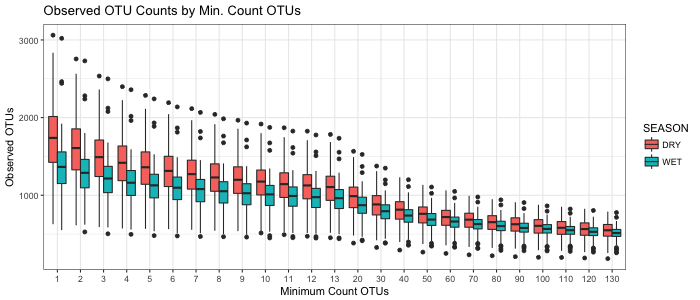

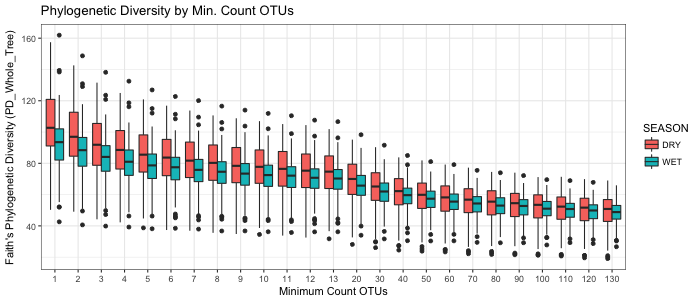

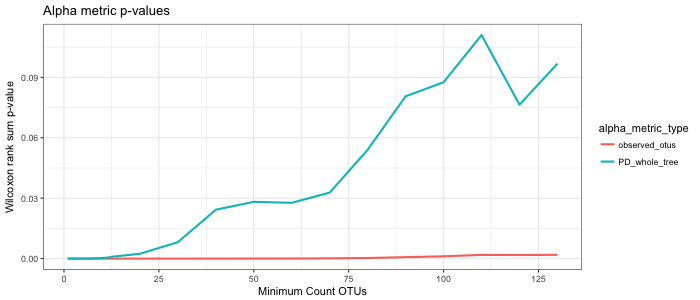

In [22]:
%%R -h 300 -w 700 -i adiv_min_otusDF,adiv_min_otus_pvalues,sort_n
library(ggplot2)
seasonal_colors = c('#FFBF00', '#4A942C')

adiv_min_otusDF$labelx <- factor(adiv_min_otusDF$n, levels=sort_n)
adiv_min_otus_pvalues$labelx <- factor(adiv_min_otus_pvalues$n, levels=sort_n)

p <- ggplot(adiv_min_otusDF, aes(x=labelx)) +
    geom_boxplot(aes(fill=SEASON, y=observed_otus)) +
    ggtitle('Observed OTU Counts by Min. Count OTUs') +
    ylab("Faith's Phylogenetic Diversity (PD_Whole_Tree)") +
    xlab("Minimum Count OTUs") +
    theme_bw()
print(p)
p <- ggplot(adiv_min_otusDF, aes(x=labelx)) +
    geom_boxplot(aes(fill=SEASON, y=PD_whole_tree)) +
    ggtitle('Phylogenetic Diversity by Min. Count OTUs') +
    ylab("Faith's Phylogenetic Diversity (PD_Whole_Tree)") +
    xlab("Minimum Count OTUs") +
    theme_bw()
print(p)

p <- ggplot(adiv_min_otus_pvalues, aes(x=n, y=pvalue, color=alpha_metric_type)) +
    geom_line(size=1) +
    ggtitle('Alpha metric p-values') +
    ylab("Wilcoxon rank sum p-value") +
    xlab("Minimum Count OTUs") +
    scale_x_continuous(breaks = round(seq(0, 130, by = 25),1)) +
    theme_bw()
print(p)

<h3>Diversity metrics across OTU table rarefaction levels</h3>

Here we calculate diversity metrics across rarefaction levels of the
rarefied OTU table selected for these analyses:

```
multiple_rarefactions.py -i otu_tables/otu_table_d13k_n13_d11k.biom -m 1000 -x 11000 -s 2000 -n 5 -o otu_tables_rarefied
alpha_diversity.py -i otu_tables_rarefied -o adiv_otu_tables_rarefied -t rep_set.tre
```

In [23]:
# Here we concatenate the outputted alpha diversity metrics
adiv_rarefaction = []
sort_d = []
for d in range(1000,13000,2000):
    sort_d.append(d)
    adiv = pd.read_csv('./adiv_otu_tables_rarefied/alpha_rarefaction_' + str(d) + '_0.txt', sep="\t")
    adiv['d'] = d
    if len(adiv_rarefaction):
        adiv_rarefaction = pd.concat([adiv_rarefaction, adiv])
    else:
        adiv_rarefaction = adiv
adiv_rarefaction.columns = ['#SampleID'] + adiv_rarefaction.columns.tolist()[1:]
adiv_rarefaction = adiv_rarefaction.merge(mapping[['#SampleID', 'SEASON']])

In [24]:
# Derive Wilcoxon rank sum stats
adiv_rarefaction_pvalues = []
for alpha_metric_type in ['observed_otus', 'PD_whole_tree']:
    for d in sort_d:
        _adiv_rarefactionDF = adiv_rarefaction[adiv_rarefaction.d == d][['SEASON', alpha_metric_type]]
        adiv_rarefaction_pvalues.append([
            d,
            alpha_metric_type,
            ranksums(
                _adiv_rarefactionDF[_adiv_rarefactionDF.SEASON == "WET"][alpha_metric_type],
                _adiv_rarefactionDF[_adiv_rarefactionDF.SEASON == "DRY"][alpha_metric_type]
            ).pvalue
        ])
adiv_rarefaction_pvalues = pd.DataFrame(adiv_rarefaction_pvalues)
adiv_rarefaction_pvalues.columns = ['d', 'alpha_metric_type', 'pvalue']

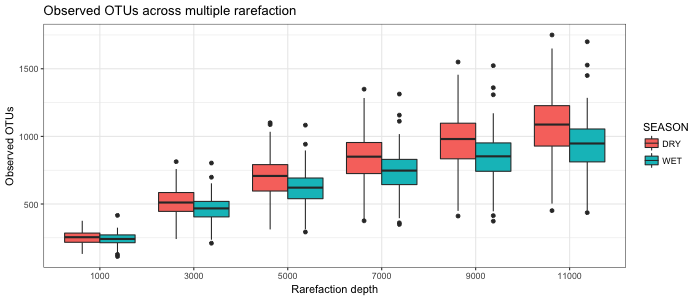

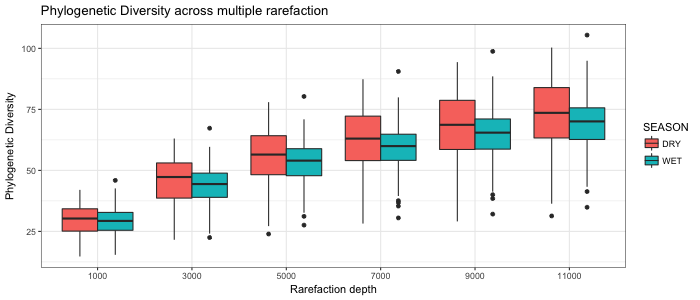

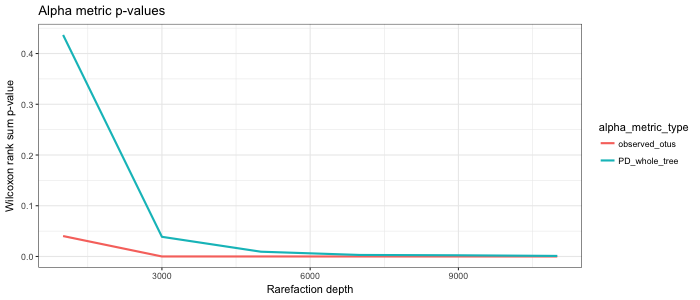

In [25]:
%%R -h 300 -w 700 -i adiv_rarefaction,adiv_rarefaction_pvalues,sort_d
library(ggplot2)

adiv_rarefaction$labelx <- factor(adiv_rarefaction$d, levels=sort_d)

p <- ggplot(adiv_rarefaction, aes(x=labelx)) +
    geom_boxplot(aes(fill=SEASON, y=observed_otus)) +
    ggtitle("Observed OTUs across multiple rarefaction ") +
    ylab("Observed OTUs") +
    xlab("Rarefaction depth") +
    theme_bw()
print(p)
p <- ggplot(adiv_rarefaction, aes(x=labelx)) +
    geom_boxplot(aes(fill=SEASON, y=PD_whole_tree)) +
    ggtitle("Phylogenetic Diversity across multiple rarefaction ") +
    ylab("Phylogenetic Diversity") +
    xlab("Rarefaction depth") +
    theme_bw()
print(p)

p <- ggplot(adiv_rarefaction_pvalues, aes(x=d, y=pvalue, color=alpha_metric_type)) +
    geom_line(size=1) +
    ggtitle('Alpha metric p-values') +
    ylab("Wilcoxon rank sum p-value") +
    xlab("Rarefaction depth") +
    theme_bw()
print(p)